In [1]:
from __future__ import division
import argparse
import pandas as pd

# useful stuff
import numpy as np
from scipy.special import expit
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import os
import io
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import re
import json

In [ ]:
def text2sentences(path, stopwords):
 # feel free to make a better tokenization/pre-processing
    sentences = []
    with open(path) as f:
        for l in f:
            sentences.append(clean_sentence(l, stopwords))
    return sentences

In [ ]:
def loadStopwords(path):
    #import stopwords file
    stopwords_file = open(path, 'r')
    stopwords = []
    for word in stopwords_file:
        stopwords.append(word.strip('\n'))

    return stopwords

In [ ]:
def clean_sentence(sentence, stopwords):
    rx = re.compile('\W+')
    sentence = str(sentence).lower().split()
    sentence = [rx.sub(' ',i).strip() for i in sentence if i not in stopwords and rx.sub(' ',i).strip()!= '']
    return sentence

In [ ]:
path_stopwords = '/home/louis/Documents/Data_science/YJ_PROJECT/Data/Data/stopwords.txt'
stopwords = loadStopwords(path_stopwords)

In [ ]:
#DEMOCRATIE_ET_CITOYENNETE

with open("/home/louis/Documents/Data_science/YJ_PROJECT/Data/Data/LA_FISCALITE_ET_LES_DEPENSES_PUBLIQUES.json") as json_file:
    json_data = json.load(json_file) 

l=len(json_data) 
fiscalite_plus_juste_resp= open("fiscalite_plus_juste_resp.txt", "w+")
for i in range(l):
    resp=json_data[i]['responses'][1]['value']
    if resp!=None:
        fiscalite_plus_juste_resp.write(resp)
        fiscalite_plus_juste_resp.write("\n")

fiscalite_plus_juste_resp.close()

In [ ]:
path_data = '/home/louis/Documents/Data_science/YJ_PROJECT/Data/Data/fiscalite_plus_juste_resp.txt'
tokenize_sentences=text2sentences(path_data,stopwords)

In [ ]:
word_2_num={}
i=0
for sentence in tokenize_sentences:
    for token in sentence:
        if token not in word_2_num.keys():
            i+=1
            word_2_num[token]=str(i)

In [ ]:
sentence_max = 100
fiscalite_plus_juste_el = open("fiscalite_plus_juste_el.edgelist", "w+")
for sentence in tokenize_sentences:
    if sentence:
        for i,token in enumerate(sentence):
            for neighbor in sentence[min(0,i-10):max(i+10,len(sentence))]:
                if token!=neighbor:
                    line=word_2_num[token]+" "+word_2_num[neighbor]
                    fiscalite_plus_juste_el.write(line)
                    fiscalite_plus_juste_el.write('\n')
fiscalite_plus_juste_el.close()

In [9]:
#load deepwalk output from https://github.com/phanein/deepwalk
folder='/home/louis/Documents/Data_science/YJ_PROJECT/deepwalk/'
node=[]
data_emb=[]
with io.open(os.path.join(folder, "fiscalite.embeddings"), encoding='utf-8') as f:
    for i, line in enumerate(f):
        if i>0:
            node_, vec = line.rstrip().split(' ', 1)

            data_emb.append(np.fromstring(vec, sep=' ').tolist())
            node.append(node_)
       

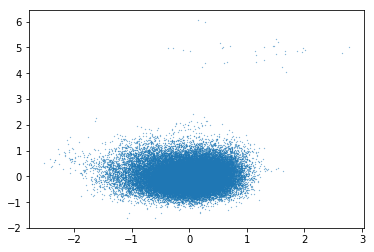

In [10]:
#PCA on follower network

### VERY LONG COMPUTING TIME , 60H ####
%matplotlib inline
pca= PCA(n_components=2, random_state=0)
Y = pca.fit_transform(data_emb)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords,s=0.05)
plt.show()

In [ ]:
#t-SNE on follower network

### VERY LONG COMPUTING TIME , 60H ####
%matplotlib inline
tsne = TSNE(n_components=2, random_state=0)
Y = tsne.fit_transform(data_emb)

x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords,s=0.05)
plt.show()